In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import urllib.parse
import requests
import matplotlib.pyplot as plt
from datetime import datetime

# Data Acquisition and Cleaning: Labs
## Author Solutions

### 1. Messy and Tidy Data
In this exercise, we'll be fixing some of the most common mistakes which result in messy data. We'll read a messy dataset and then try to tidy it up.

* **The table header contains values**. We'll read a distribution of income by religion. The dataset contains values as columns. We have to melt them and create a new, tidy dataset.

In [2]:
pew_data = pd.read_csv("data_tidying/pew.csv")
pew_data.head()

,religion,<$10k,$10-20k,$20-30k,$30-40k,$40-50k,$50-75k,$75-100k,$100-150k,>150k,Don't know/refused
0,Agnostic,27,34,60,81,76,137,122,109,84,96
1,Atheist,12,27,37,52,35,70,73,59,74,76
2,Buddhist,27,21,30,34,33,58,62,39,53,54
3,Catholic,418,617,732,670,638,1116,949,792,633,1489
4,Don’t know/refused,15,14,15,11,10,35,21,17,18,116


In [3]:
pew_data_tidy = pd.melt(pew_data, 
    id_vars = ["religion"], # Identifier variables (all others are "unpivoted")
    var_name = "income", # Variable
    value_name = "frequency") # Value
pew_data_tidy.head()

,religion,income,frequency
0,Agnostic,<$10k,27
1,Atheist,<$10k,12
2,Buddhist,<$10k,27
3,Catholic,<$10k,418
4,Don’t know/refused,<$10k,15


* **Multiple values stored in one column**. We'll read a data of tuberculosis cases. Each column encodes three things: the first letter is "m" or "f" which corresponds to "male" and "female", and the numbers after that correspond to a age range. For example, "m04" encodes "male, 0-4 years old", "f1524" encodes "female, 15-24 years old" and so on. We have to split the groups and melt them into "gender" and "age range" columns. There are also a lot of NaNs which we'll have to get rid of.

In [4]:
tb_data = pd.read_csv("data_tidying/tb.csv")
tb_data.head()

,iso2,year,m04,m514,m014,m1524,m2534,m3544,m4554,m5564,...,f04,f514,f014,f1524,f2534,f3544,f4554,f5564,f65,fu
0,AD,1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AD,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AD,1991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AD,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AD,1993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Edit m014 to m1014 and f014 to f1014 which are the correct column names
tb_data.rename(columns = {"m014": "m1014", "f014": "f1014"}, inplace = True)

# Melt the values
tb_tidy = pd.melt(tb_data, id_vars = ["iso2","year"], value_name = "cases", var_name = "sex_and_age")

# Separate the columns and merge back
parts = tb_tidy["sex_and_age"].str.extract("(\D)(\d*)(\d{2})", expand = True)
parts.columns = ["sex", "age_lower", "age_upper"]
parts["age"] = parts["age_lower"] + "-" + parts["age_upper"]
tb_tidy = pd.concat([tb_tidy, parts], axis = 1)
# Fix the "boundary" names by hand
tb_tidy.age.replace(["-04", "-65"], ["0-4", "65+"], inplace = True)

# Remove missing values and sort them
tb_tidy = tb_tidy.drop(["sex_and_age", "age_lower", "age_upper"], axis = 1)
tb_tidy = tb_tidy.dropna()
tb_tidy = tb_tidy.sort_values(by = ["iso2", "year", "sex", "age", "cases"])

# The index is now wrong, reindex to make it better
tb_tidy = tb_tidy.reset_index()
del tb_tidy["index"]
tb_tidy.head(10)

,iso2,year,cases,sex,age
0,AD,1996,0.0,f,10-14
1,AD,1996,1.0,f,15-24
2,AD,1996,1.0,f,25-34
3,AD,1996,0.0,f,35-44
4,AD,1996,0.0,f,45-54
5,AD,1996,1.0,f,55-64
6,AD,1996,0.0,f,65+
7,AD,1996,0.0,m,10-14
8,AD,1996,0.0,m,15-24
9,AD,1996,0.0,m,25-34


* **Variables are stored in both rows and columns**. We'll read daily weather reports from Mexico from 2010. First, we'll need to melt the days of the month (and remove invalid days, e.g. 31 April). Then, we have to pivot the min and max temperature (this is the reverse of melting).

In [6]:
temp_data = pd.read_csv("data_tidying/weather.csv")
temp_data.head()

,id,year,month,element,d1,d2,d3,d4,d5,d6,...,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31
0,MX17004,2010,1,tmax,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.8,NaN
1,MX17004,2010,1,tmin,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.5,NaN
2,MX17004,2010,2,tmax,NaN,27.3,24.1,NaN,NaN,NaN,...,NaN,29.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MX17004,2010,2,tmin,NaN,14.4,14.4,NaN,NaN,NaN,...,NaN,10.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MX17004,2010,3,tmax,NaN,NaN,NaN,NaN,32.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
temp_data_tidy = pd.melt(temp_data, id_vars = ["id", "year", "month", "element"], var_name = "day")
temp_data_tidy["day"] = temp_data_tidy["day"].str.extract("(\d+)", expand = True).astype(np.int64)

# Remove missing days (e. g. 31st April) and dates with no records
temp_data_tidy = temp_data_tidy.dropna()
temp_data_tidy["date"] = pd.to_datetime(temp_data_tidy[["year", "month", "day"]])
temp_data_tidy = temp_data_tidy.drop(["year", "month", "day"], axis = 1)

# Pivot the elements back to their own columns
temp_data_tidy = temp_data_tidy.pivot_table(index = ["id", "date"], columns = "element", values = "value")

# Pivoting returns a multi-indexed element, go back to a flat DataFrame
temp_data_tidy.reset_index(inplace = True)
temp_data_tidy.head()

element,id,date,tmax,tmin
0,MX17004,2010-01-30,27.8,14.5
1,MX17004,2010-02-02,27.3,14.4
2,MX17004,2010-02-03,24.1,14.4
3,MX17004,2010-02-11,29.7,13.4
4,MX17004,2010-02-23,29.9,10.7


There are two more common errors related to multiple entities and their connections.
* **One type in multiple tables**
* **Multiple types in one table**

We can split or join the tables as needed, to tidy them up (this is also known as the **fourth normal form** of a table). We'll see an example of the last error in the next lab.

### 2. Billboard Dataset
We'll read a dataset containing information about songs and their positions in Billboard's Top 100. The dataset follows a song from the start to the 76th week. If a song is in the top 100 shorter, the remaining weeks are NaNs.

We have to do two main things. First, we need to extract week numbers into a single column and convert week numbers to dates. After that, since the dataset contains a lot of repetition, we'll split it in two parts: songs and ranks (ratings). Each song will have a collection of ratings and the relation between these two will be via the song's ID.

In [8]:
billboard = pd.read_csv("data_tidying/billboard.csv")
billboard.head()

,year,artist,track,time,date.entered,wk1,wk2,wk3,wk4,wk5,...,wk67,wk68,wk69,wk70,wk71,wk72,wk73,wk74,wk75,wk76
0,2000,2 Pac,Baby Don't Cry (Keep...,4:22,2000-02-26,87,82.0,72.0,77.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,2Ge+her,The Hardest Part Of ...,3:15,2000-09-02,91,87.0,92.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,3 Doors Down,Kryptonite,3:53,2000-04-08,81,70.0,68.0,67.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,3 Doors Down,Loser,4:24,2000-10-21,76,76.0,72.0,69.0,67.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,504 Boyz,Wobble Wobble,3:35,2000-04-15,57,34.0,25.0,17.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Melt the dataset - use week numbers as values
id_vars = ["year", "artist", "track", "time", "date.entered"]

billboard_tidy = pd.melt(billboard, id_vars = id_vars, var_name = "week", value_name = "rank")

# Get week numbers and remove NaNs (invalid or missing weeks)
billboard_tidy["week"] = billboard_tidy["week"].str.extract("(\d+)", expand = False).astype(int)
billboard_tidy = billboard_tidy.dropna()

# Get dates from date entered and week number
billboard_tidy["date"] = pd.to_datetime(
    billboard_tidy["date.entered"]) + pd.to_timedelta(billboard_tidy["week"], unit = "w") - pd.DateOffset(weeks = 1)
billboard_tidy.drop(["date.entered", "week"], axis = 1, inplace = True)

# Sort the values to look better
billboard_tidy = billboard_tidy.sort_values(by = ["year", "artist", "track", "rank"])

billboard_tidy

,year,artist,track,time,rank,date
634,2000,2 Pac,Baby Don't Cry (Keep...,4:22,72.0,2000-03-11
951,2000,2 Pac,Baby Don't Cry (Keep...,4:22,77.0,2000-03-18
317,2000,2 Pac,Baby Don't Cry (Keep...,4:22,82.0,2000-03-04
0,2000,2 Pac,Baby Don't Cry (Keep...,4:22,87.0,2000-02-26
1268,2000,2 Pac,Baby Don't Cry (Keep...,4:22,87.0,2000-03-25
1585,2000,2 Pac,Baby Don't Cry (Keep...,4:22,94.0,2000-04-01
1902,2000,2 Pac,Baby Don't Cry (Keep...,4:22,99.0,2000-04-08
318,2000,2Ge+her,The Hardest Part Of ...,3:15,87.0,2000-09-09
1,2000,2Ge+her,The Hardest Part Of ...,3:15,91.0,2000-09-02
635,2000,2Ge+her,The Hardest Part Of ...,3:15,92.0,2000-09-16


In [10]:
# Now that we have a tidy dataset, let's separate it into two parts: songs and ranks
# To create the songs, we copy the original dataset, select the song columns and retrieve the unique items only
songs = billboard_tidy[["year", "artist", "track", "time"]].drop_duplicates()
# We also need to reindex to keep indices clean and sequential
songs = songs.reset_index(drop = True)
songs["song_id"] = songs.index

# We create the ranks in the "opposite" way - merging the songs with the original dataset and filtering out the rank columns
ranks = pd.merge(billboard_tidy, songs, on = ["year", "artist", "track", "time"])
ranks = ranks[["song_id", "date","rank"]]
print(songs.head(10))
print(ranks.head(10))

   year          artist                    track  time  song_id
0  2000           2 Pac  Baby Don't Cry (Keep...  4:22        0
1  2000         2Ge+her  The Hardest Part Of ...  3:15        1
2  2000    3 Doors Down               Kryptonite  3:53        2
3  2000    3 Doors Down                    Loser  4:24        3
4  2000        504 Boyz            Wobble Wobble  3:35        4
5  2000            98^0  Give Me Just One Nig...  3:24        5
6  2000         A*Teens            Dancing Queen  3:44        6
7  2000         Aaliyah            I Don't Wanna  4:15        7
8  2000         Aaliyah                Try Again  4:03        8
9  2000  Adams, Yolanda            Open My Heart  5:30        9
   song_id       date  rank
0        0 2000-03-11  72.0
1        0 2000-03-18  77.0
2        0 2000-03-04  82.0
3        0 2000-02-26  87.0
4        0 2000-03-25  87.0
5        0 2000-04-01  94.0
6        0 2000-04-08  99.0
7        1 2000-09-09  87.0
8        1 2000-09-02  91.0
9        1 2000-

### 3. Reading Data from Various Sources
In this exercise, we'll be reading data from Excel, SQL Server, Web services and HTML. Note that for most exercises you'll need to perform additional steps in order to get the files needed.

In [11]:
# Reading from Excel: Download and extract this dataset in your working directory:
# https://www.kaggle.com/akshay4/road-accidents-incidence

# We'll print the dataset before and after the transformation.
# We're transforming only the vehicle_type column. Others are very similar and can be automated very easily.
# This is left as an exercise for the reader :)
accidents = pd.read_csv("Kaagle_Upload.csv", low_memory = False)
variables = pd.read_excel("Road-Accident-Safety-Data-Guide (1).xls", sheetname = None) # Read all worksheets
print(accidents[["accident_index", "vehicle_type"]].head(10))

vehicle_types = variables["Vehicle Type"].set_index("code")
vehicle_types = vehicle_types.rename(columns = {"label": "vehicle_type"})
vehicle_type_map = vehicle_types.to_dict()

accidents = accidents.replace(vehicle_type_map)

print(accidents[["accident_index", "vehicle_type"]].head(10))

  accident_index  vehicle_type
0  201506E098757             9
1  201506E098766             9
2  201506E098766             9
3  201506E098777            20
4  201506E098780             9
5  201506E098780             1
6  201506E098792             3
7  201506E098792             9
8  201506E098804             9
9  201506E098826             9
  accident_index                     vehicle_type
0  201506E098757                              Car
1  201506E098766                              Car
2  201506E098766                              Car
3  201506E098777  Goods over 3.5t. and under 7.5t
4  201506E098780                              Car
5  201506E098780                      Pedal cycle
6  201506E098792       Motorcycle 125cc and under
7  201506E098792                              Car
8  201506E098804                              Car
9  201506E098826                              Car


In [12]:
# Write your username and password into a file and read them. I've removed mine
# because of secirity reasons (it's never a good idea to have passwords flying around)
with open("db-credentials.txt", "r") as c:
    [user, password] = c.readline().split(",")
    
params = urllib.parse.quote_plus(
    "DRIVER={SQL Server};SERVER=tcp:ds-course.database.windows.net,1433;DATABASE=ds-course;UID=" + user + ";PWD=" + password)
con = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params, legacy_schema_aliasing = True)
addresses = pd.read_sql_table("Address", con, schema = "SalesLT")
print(addresses.head())

sql = """
select p.ProductID, p.Name as ProductName, c.Name as CategoryName
from SalesLT.Product as p
join SalesLT.ProductCategory as c 
on p.ProductCategoryID = c.ProductCategoryID
"""
products_with_categories = pd.read_sql_query(sql, con)
print(products_with_categories.head())

   AddressID         AddressLine1 AddressLine2      City StateProvince  \
0          9    8713 Yosemite Ct.         None   Bothell    Washington   
1         11  1318 Lasalle Street         None   Bothell    Washington   
2         25     9178 Jumping St.         None    Dallas         Texas   
3         28     9228 Via Del Sol         None   Phoenix       Arizona   
4         32    26910 Indela Road         None  Montreal        Quebec   

   CountryRegion PostalCode                               rowguid ModifiedDate  
0  United States      98011  268AF621-76D7-4C78-9441-144FD139821A   2006-07-01  
1  United States      98011  981B3303-ACA2-49C7-9A96-FB670785B269   2007-04-01  
2  United States      75201  C8DF3BD9-48F0-4654-A8DD-14A67A84D3C6   2006-09-01  
3  United States      85004  12AE5EE1-FC3E-468B-9B92-3B970B169774   2005-09-01  
4         Canada    H1Y 2H5  84A95F62-3AE8-4E7E-BBD5-5A6F00CD982D   2006-08-01  
   ProductID              ProductName    CategoryName
0        771  M

In [13]:
with open("edmunds-key.txt", "r") as k:
    key = k.readline()
car_makes = requests.get("https://api.edmunds.com/api/vehicle/v2/makes?state=new" +
                         "&year=2017&view=basic&fmt=json&api_key=" + key).json()

makes = pd.DataFrame(car_makes["makes"])
make_models = makes.models
del makes["models"]
makes.head()

,id,name,niceName
0,200002038,Acura,acura
1,200464140,Alfa Romeo,alfa-romeo
2,200001769,Aston Martin,aston-martin
3,200000001,Audi,audi
4,200000081,BMW,bmw


In [14]:
url = "http://www.fdic.gov/bank/individual/failed/banklist.html"
banks = pd.read_html(url)[0] # Returns a list of tables
print(banks.shape)
banks.head()

(549, 7)


,Bank Name,City,ST,CERT,Acquiring Institution,Closing Date,Updated Date
0,Seaway Bank and Trust Company,Chicago,IL,19328,State Bank of Texas,"January 27, 2017","February 3, 2017"
1,Harvest Community Bank,Pennsville,NJ,34951,First-Citizens Bank & Trust Company,"January 13, 2017","January 26, 2017"
2,Allied Bank,Mulberry,AR,91,Today's Bank,"September 23, 2016","November 17, 2016"
3,The Woodbury Banking Company,Woodbury,GA,11297,United Bank,"August 19, 2016","November 17, 2016"
4,First CornerStone Bank,King of Prussia,PA,35312,First-Citizens Bank & Trust Company,"May 6, 2016","September 6, 2016"


### 4. Cleaning Data
We'll inspect a dataset showing weather records. On the way, we'll clean it and prepare it for modelling.

Let's first read the dataset and inspect the head, tail and shape (number of observations and variables):

In [15]:
weather = pd.read_csv(
    "https://raw.githubusercontent.com/apawlik/2014-04-09-GARNET/gh-pages/lessons/garnet/pandas/data/weather_year.csv")
print("Shape: " + str(weather.shape))
print(weather.head())
print(weather.tail())

Shape: (366, 23)
         EDT  Max TemperatureF  Mean TemperatureF  Min TemperatureF  \
0  2012-3-10                56                 40                24   
1  2012-3-11                67                 49                30   
2  2012-3-12                71                 62                53   
3  2012-3-13                76                 63                50   
4  2012-3-14                80                 62                44   

   Max Dew PointF  MeanDew PointF  Min DewpointF  Max Humidity  \
0              24              20             16            74   
1              43              31             24            78   
2              59              55             43            90   
3              57              53             47            93   
4              58              52             43            93   

    Mean Humidity   Min Humidity       ...         Max VisibilityMiles  \
0              50             26       ...                          10   
1          

One thing we can fix right away is column names - we can make them more "pythonic" in order to make calling them with the "dot" syntax easier (e.g. `weather.mean_temp`).

In [16]:
weather.columns = ["date", "max_temp", "mean_temp", "min_temp", "max_dew",
                   "mean_dew", "min_dew", "max_humidity", "mean_humidity",
                   "min_humidity", "max_pressure", "mean_pressure",
                   "min_pressure", "max_visibilty", "mean_visibility",
                   "min_visibility", "max_wind", "mean_wind", "min_wind",
                   "precipitation", "cloud_cover", "events", "wind_dir"]

A common thing we do at the beginning is to check the column data types (to see if everything was parsed correctly) and check for NaNs (and possibly remove them or replace them with sentinel values).

In [17]:
print(weather.dtypes)
# Precipitation is a string (object). We can see it contains "T" for trace amounts
# In order to fix this we'll replace it with a very small value (but not 0, there's a reason why
# it is "trace" instead of 0)
weather.precipitation = weather.precipitation.replace("T", 1e-6).astype(float)
print(weather.dtypes)
print()

print("Null values:")
for col in weather:
    print(col, pd.isnull(weather[col]).any())
print()

# We see there are NaNs in events and min_wind. There's only one min_wind value missing and we'll replace it with 0.
# Another good (or even better) choice would be to replace it with the mean of the column but let's use 0.
# Also, we'll replace the events with an empty string where there aren't any
print("NaNs in min_wind:")
print(weather.min_wind[pd.isnull(weather.min_wind)])
weather.min_wind.fillna(0, inplace = True)
weather.events.fillna("", inplace = True)

date                object
max_temp             int64
mean_temp            int64
min_temp             int64
max_dew              int64
mean_dew             int64
min_dew              int64
max_humidity         int64
mean_humidity        int64
min_humidity         int64
max_pressure       float64
mean_pressure      float64
min_pressure       float64
max_visibilty        int64
mean_visibility      int64
min_visibility       int64
max_wind             int64
mean_wind            int64
min_wind           float64
precipitation       object
cloud_cover          int64
events              object
wind_dir             int64
dtype: object
date                object
max_temp             int64
mean_temp            int64
min_temp             int64
max_dew              int64
mean_dew             int64
min_dew              int64
max_humidity         int64
mean_humidity        int64
min_humidity         int64
max_pressure       float64
mean_pressure      float64
min_pressure       float64
max_visibilty 

Now that we have removed / replaced NaNs, we'd usually do some melting / pivoting to tidy up the data. This dataset appears tidy so let's proceed. Let's find the ranges of the columns so we know what values we're dealing with. It's also a good idea to convert the date strings to real dates (to see the date ranges and to be able to filter based on them). This is a time series, so it's even better to use the date column as index of the table.

In [18]:
weather.describe().T # I prefer to look at the transposed version of the table - it seems easier to look at

,count,mean,std,min,25%,50%,75%,max
max_temp,366.0,66.803279,20.361247,16.00,51.00,69.00,84.0000,106.00
mean_temp,366.0,55.683060,18.436506,11.00,41.00,59.00,70.7500,89.00
min_temp,366.0,44.101093,17.301141,1.00,30.00,47.00,57.7500,77.00
max_dew,366.0,49.549180,16.397178,0.00,36.00,54.50,62.0000,77.00
mean_dew,366.0,44.057377,16.829996,-3.00,30.00,48.00,57.0000,72.00
min_dew,366.0,37.980874,17.479449,-5.00,24.00,41.00,51.0000,71.00
max_humidity,366.0,90.027322,9.108438,54.00,85.00,93.00,96.0000,100.00
mean_humidity,366.0,67.860656,9.945591,37.00,61.25,68.00,74.0000,95.00
min_humidity,366.0,45.193989,15.360261,15.00,35.00,42.00,54.0000,90.00
max_pressure,366.0,30.108907,0.172189,29.64,29.99,30.10,30.2100,30.60


In [19]:
def string_to_date(date_string):
    return datetime.strptime(date_string, "%Y-%m-%d")

weather.date = weather.date.apply(string_to_date)
weather.index = weather.date
weather = weather.drop("date", axis = 1)

Now, we'll want to do something which is not directly related to cleaning data for scientific usage but most machine learning algorithms depend on it. This is extracting indicator (or dummy) variables for the categorical columns. In this case we have events, so let's extract them as dummy variables:

In [20]:
weather = pd.get_dummies(weather)
weather.head()

,max_temp,mean_temp,min_temp,max_dew,mean_dew,min_dew,max_humidity,mean_humidity,min_humidity,max_pressure,...,events_Fog-Rain-Snow,events_Fog-Rain-Snow-Thunderstorm,events_Fog-Rain-Thunderstorm,events_Fog-Snow,events_Fog-Thunderstorm,events_Rain,events_Rain-Snow,events_Rain-Thunderstorm,events_Snow,events_Thunderstorm
date,,,,,,,,,,,,,,,,,,,,,
2012-03-10,56,40,24,24,20,16,74,50,26,30.53,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-03-11,67,49,30,43,31,24,78,53,28,30.37,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-03-12,71,62,53,59,55,43,90,76,61,30.13,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-03-13,76,63,50,57,53,47,93,66,38,30.12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-03-14,80,62,44,58,52,43,93,68,42,30.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we'll perform some exploratory data analysis using `pandas`.

In [21]:
# Exploring subsets
# Row subsets
print(len(weather[weather.max_temp < 20]))
print(len(weather[(weather.min_temp >= 20) & (weather.min_temp <= 32)]))

# Column subsets
print(weather[["min_temp", "max_temp", "mean_pressure"]].head(10))

# Row and column subsets
# This becomes ugly very fast, it's better to extract variables
print(weather[
    (weather.min_temp > 20) & (weather.max_temp <= 32)][[
        "min_temp", "max_temp"]].head(10))

2
85
            min_temp  max_temp  mean_pressure
date                                         
2012-03-10        24        56          30.45
2012-03-11        30        67          30.27
2012-03-12        53        71          29.99
2012-03-13        50        76          30.06
2012-03-14        44        80          30.10
2012-03-15        58        79          30.08
2012-03-16        52        75          30.10
2012-03-17        46        78          30.11
2012-03-18        59        80          30.07
2012-03-19        59        84          30.03
            min_temp  max_temp
date                          
2012-11-24        21        31
2012-12-21        22        29
2012-12-29        23        32
2013-03-02        27        32
2013-03-06        29        32


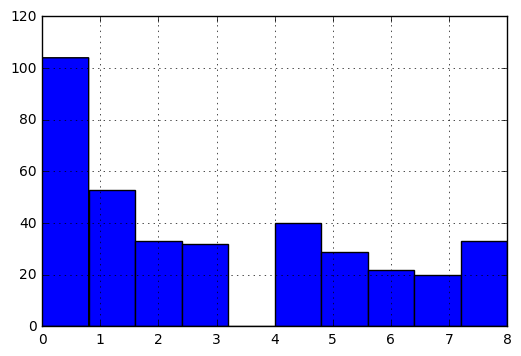

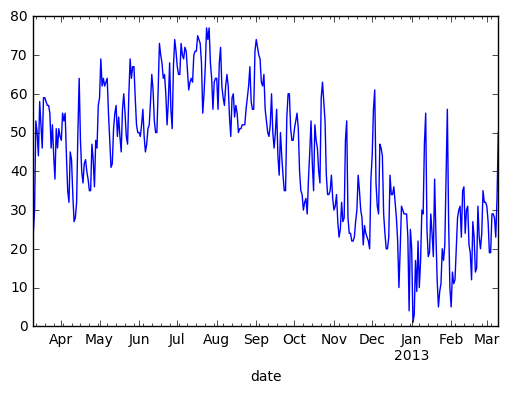

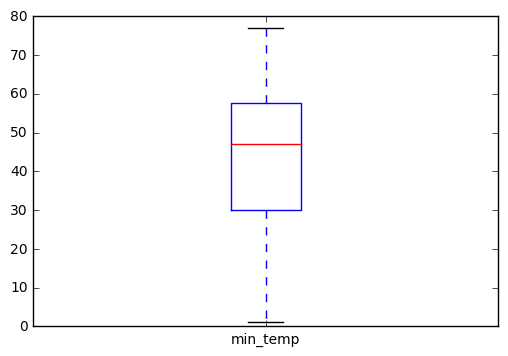

In [22]:
# Plotting charts
# Of course, we can create much more flexible plots with matplotlib
# but pandas plots do give some information
weather.cloud_cover.hist()
plt.show()
weather.min_temp.plot()
plt.show()
weather.min_temp.plot(kind = "box")
plt.show()